# **Jupyter notebook (Caracterización de redes y topologías biológicas)**
Autores: **Diego Mañanes Cayero** y **Alejandro Martín Muñoz**

## **Práctica 2: Gráfos Aleatorios, Regulares, de Mundo pequeño y Libres de Escala**

### 1. Estudiar las propiedeades de un grafo aleatorio.

**a. Usando la función ``gnp_random_graph(n,p)`` de NetworkX, implementad una rutina Python ``L_C_Aleatorio`` que devuelva el valor promedio de los coeficientes C (índice de clusterización promedio) y L (camino característico) de un conjunto de n_graph grafos aleatorios de n nodos y probabilidad p.** El formato de la función debe ser:

``[l,c] = L_C_Aleatorio(n_graph,n,p)``

In [1]:
# importación de librerías
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import pickle
import os.path
import string
import re

La función ``L_C_Aleatorio`` se ha construido de manera que no solo devuelve los valores de $C$ y $L$, sino también el grado medio ($K$) de cada uno de los grafos generados. Respecto a la posibilidad de generar grafos inconexos, mediante el argumento ``Lmax`` es posible decidir cuál va a ser el comportamiento de la función a la hora de calcular el valor de $L$:

* Si ``Lmax == True`` (por defecto), la función tomará $L = N - 1$, valor máximo que dicho parámetro puede tener. 
* Si ``Lmax != True``, la función calculará el parámetro $L$ para la componente conexa de mayor tamaño. Dicho comportamiento puede no tener sentido por el hecho de que se desconoce el tamaño de esa componente conexa, pero puede ser útil a la hora de analizar cómo evoluciona la estructura del grafo con diferentes valores de $P$. 

Cabe destacar que, dado que en la versión 2.4 del módulo NetworkX se ha retirado la función ``nx.connected_component_subgraphs()``, la cual devuelve las componentes conexas del grafo, se ha creado la función lambda ``max_connected`` que devuelve la componente conexa de mayor tamaño.

In [2]:
# Creación de la función max_connected
max_connected = lambda graph: max([graph.subgraph(c) for c in nx.connected_components(graph)],
                                   key = len)

# Definición de la función L_C_Aleatorio
def L_C_Aleatorio(n_graph, n, P, Lmax = True):
    C = []
    L = []
    K = []
    for graph in range(n_graph):
        G = nx.gnp_random_graph(n, P)
        C.append(nx.average_clustering(G))
        # Cuando el grafo es conexo, se puede usar la función de cálculo del camino característico pero, cuando
        # no, L = n - 1 porque es el valor máximo de camino característico.
        if nx.is_connected(G):
            L.append(nx.average_shortest_path_length(G))
        else:
            if Lmax:
                L.append(n - 1)
            else:
                G_max = max_connected(G)
                L.append(nx.average_shortest_path_length(G_max))
        Degree = dict(nx.degree(G)).values()
        K.append(sum(Degree)/len(Degree))
        
    return round(sum(L)/len(L), 3), round(sum(C)/len(C), 3), round(sum(K)/len(K), 3)

**b. Usando la rutina anterior, dibujar el comportamiento de L, C para distintos valores de la probabilidad p y un número fijo de nodos.** 

* Tomad n=400, n_graph=20 y los siguientes valores de p: [0, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1.]

* Dibujad una gráfica que describa el comportamiento de estos dos parámetros como función de p, usad escala logarítmica en el eje x.

* ¿Para qué probabilidades p se producen cambios fase en el comportamiento los parámetros L y C?

En primer lugar, se va a llevar a cabo la simulación de 20 grafos aleatorios para cada una de las probabilidades dadas mediante la función ``L_C_Aleatorio``. Dicha función devolverá una tupla con la media de $L$, $C$ y $K$ para los 20 grafos. Dado que los tiempos de ejecución son extensos, se ha decido guardar los resultados en ficheros binarios mediante el módulo ``pickle`` de la librería estándar de Python con el protocolo establecido por defecto. 

In [3]:
Probs = [0, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1.]

if os.path.isfile("data/G_random_metrics.pkl"):
    with open("data/G_random_metrics.pkl", "rb") as file:
        G_random_metrics = pickle.load(file)
else:    
    C_results_1 = []
    L_results_1 = []
    K_results_1 = []
    for P in Probs:
        Indiv_results_1 = L_C_Aleatorio(20, 400, P)
        C_results_1.append(Indiv_results_1[1])
        L_results_1.append(Indiv_results_1[0])
        K_results_1.append(Indiv_results_1[2])

    G_random_metrics = [C_results_1, L_results_1, K_results_1]
    
    with open("data/G_random_metrics.pkl", "wb") as file:
        pickle.dump(G_random_metrics, file, -1)

A continuación, se generan los gráficos correspondientes para el estudio del comportamiento de los parámetros en función de los distintos valores de $P$. Cabe destacar que el gráfico D se corresponde con la visualización del comportamiento de $C$ y $L$ de forma conjunta. Dado que el rango de valores en el que se distribuyen los dos parámetros es diferente, se han reescalado los valores de $L$ para que su rango de valores vaya de 0 a 1 mediante la división de los mismos por el máximo (en este caso, 399).

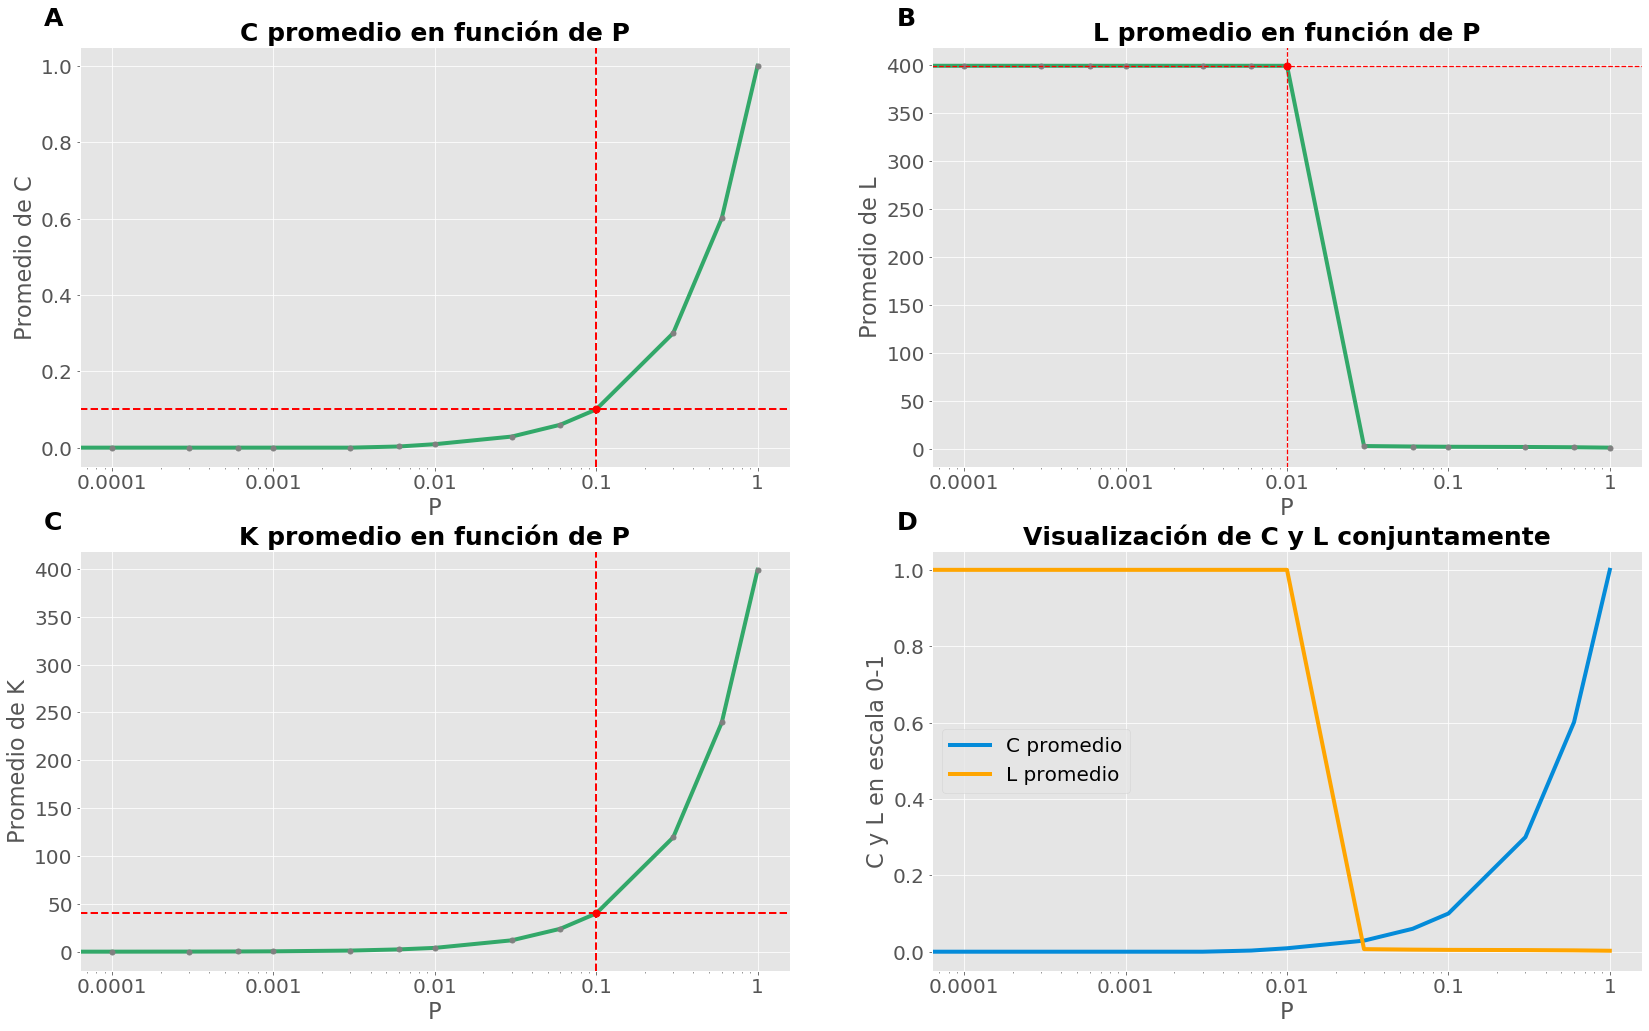

In [4]:
G_titles = ["C promedio en función de P", "L promedio en función de P", "K promedio en función de P",
            "Visualización de C y L conjuntamente"]
G_ylabels = ["Promedio de C", "Promedio de L", "Promedio de K", "C y L en escala 0-1"]
textSize = 25
lineW = 4

# Representación 
fig, axs = plt.subplots(2, 2, figsize = (28, 17))

for nax, ax in enumerate(axs.flat):
    if nax != 3:
        ax.plot(Probs, G_random_metrics[nax], linewidth = lineW, color = "#32a869")
        ax.plot(Probs, G_random_metrics[nax], "o", color = "grey", markersize = 5)
    else:
        ax.plot(Probs, G_random_metrics[0], linewidth = lineW, color = "#048bd9", label = "C promedio")
        ax.plot(Probs, np.array(G_random_metrics[1])/max(G_random_metrics[1]), linewidth = lineW,
                color = "orange", label = "L promedio")
        ax.legend(loc = "best", prop = {'size': textSize * 0.8})
    ax.set_title(G_titles[nax], fontweight = "bold", fontsize =  textSize)
    ax.text(-0.05, 1.05, string.ascii_uppercase[nax], transform = ax.transAxes, size = textSize + 0.2,
            weight = 'bold')
    ax.set_ylabel(G_ylabels[nax], fontsize = textSize * 0.9)
    ax.set_xlabel("P", fontsize = textSize * 0.9)
    ax.set_xscale("log", nonposx = 'clip')
    ax.tick_params(labelsize = textSize * 0.8)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    if (nax == 0) or (nax == 2):
        ax.plot(0.1, G_random_metrics[nax][10], 'o', markersize = 7, c = "r")
        ax.axvline(0.1, color = "red", linewidth = 2, linestyle = "dashed")
        ax.axhline(G_random_metrics[nax][10], color = "red", linewidth = 2, linestyle = "dashed")
    if nax == 1:
        ax.plot(0.01, G_random_metrics[nax][7], 'o', markersize = 7, c = "r")
        ax.axvline(0.01, color = "red", linewidth = 1.25, linestyle = "dashed")
        ax.axhline(G_random_metrics[nax][7], color = "red", linewidth = 1.25, linestyle = "dashed")

Tomando como base el modelo de Erdös–Rényi [2] para la generación de grafos aleatorios, $P$ es la probabilidad con la que existen ramas en el grafo. De tal forma, si $P = 0$, el grafo será completamente disconexo, ya que no existirá ninguna rama; mientras que, si $P = 1$, el grafo será completo, ya que existirán todas las posibles ramas entre los nodos $\left(\frac{N(N-1)}{2}\right)$ y cada uno de los nodos presentará el máximo grado posible $(N - 1)$. De hecho, en esa situación, el grafo será regular, ya que todos los nodos tendrán el mismo grado $N - 1$, presentando, por tanto, una distribución Delta de Dirac (mirar el gráfico A resultante de la siguiente celda).

Teniendo en cuenta estas premisas, se pueden interpretar los gráficos anteriores como la transición desde un grafo sin ninguna componente conexa (sin ninguna rama) en el que $C = 0$ y $L$ tiende a infinito, ya que se trata de una medida global que no puede ser calculada para grafos inconexos (por facilitar la visualización, se establece para grafos disconexos $L = N - 1$), hasta un grafo en el que todos los nodos están conectados por el número máximo de ramas y, por tanto, presenta $C = 1$, ya que estará formado por un único clúster hiperconectado; y $L = 1$, ya que desde un nodo a cualquier otro la distancia siempre será 1. En resumen, en la Ecuación 1 se presentan los valores de los parámetros para $P = 1$ y $P = 0$:

$$
  \renewcommand{\arraystretch}{1.2}
  \left\{\begin{array}{l @{\quad} l r l}
        K = 0, & C = 0, & L = N - 1, & \text{if } P = 0\\
        K = N - 1, & C = 1, & L = 1,  & \text{if } P = 1
  \end{array}\right.
\tag{1}
$$



siendo $N$ el numero de nodos del grafo (en este caso, 400). 

En base a los gráficos, se puede determinar de forma aproximada la probabilidad crítica ($P_c$) a la que los parámetros $L$ y $C$ varían su comportamiento en grafos aleatorios con 400 nodos, ya que $P$ depende de $N$:

* El comportamiento de $C$ comienza a cambiar con $P_c = 0.01$ $(10^{-2})$ (marcado en rojo, gráfico A), creciendo de forma más acentuada a partir de $P = 0.1$ $(10^{-1})$. Con $P_c = 0.01$, tanto el grado medio de los nodos (K) como el índice de clusterización (C) comienzan a aumentar exponencialmente, lo que significa que para dicho valor de $P$ se comienza a generar un único clúster, es decir, el grafo pasará a ser conexo y acabará teniendo el mismo tamaño que el tamaño máximo del grafo $\left(\frac{N(N-1)}{2}\right)$. Para valores menores de $P$, el grafo estará compuesto por $N - n$ clústeres, donde $n$ es el número de ramas, es decir, estará segmentado en $N - n$ componentes conexas (salvo cuando $P \approx 0$, si no se consideran componentes conexas a nodos sin vecinos).

* $L$ disminuye drásticamente a partir de  $P_c = 0.01$ $(10^{-2})$ (marcado en rojo, gráfico B), llegando a establecerse cerca de 1 cuando $P \approx 0.05$. Esto se debe a que, para valores de $P$ por encima de 0.01 (aproximadamente), el grafo pasa a ser conexo y, por tanto, $L$ deja de ser igual a $N - 1$; mientras que cuando $P \approx 0.05$, el grafo está suficientemente conectado como para hacer que $L$ tienda a acercarse cada vez más a 1. 

Con esta información, se puede observar que es aproximadamente en la franja $0.01 < P < 0.05$ cuando tanto $L$ como $C$ presentan valores pequeños, característica inherente de los grafos aleatorios.

También es posible estudiar el comportamiento de $K$ con respecto a $P$. Como se puede observar, la evolución de $K$ es exactamente la misma que la de $C$, lo cual es lógico por el hecho de que, para grafos aleatorios, ambos parámetros miden lo mismo, pero en escalas distintas: dado que el número de ramas aumenta conforme aumenta $P$ sin que exista ningún tipo de unión preferente, tanto $K$ como $C$ serán mayores y presentarán la misma curva de crecimiento, ya que $C = P = \frac{K}{N-1}$. Esto nos indica que, en grafos aleatorios, $P$ y $K$ son equivalentes, es decir, es equivalente decir que la estructura del grafo evoluciona en función de $P$ o de $K$. 

Gracias al hecho de poder relacionar $P$ con $K$ mediante la expresión $P = \frac{K}{N-1}$, se puede determinar $P$ de forma analítica y con mayor precisión que a través de los gráficos. Erdös–Rényi [2] demostraron que, para grafos aleatorios, cuando $K$ se acerca a 1 o es mayor que 1, se produce el aumento en el índice de clusterización (C) y, por tanto, un cambio en la estructura del grafo, pasando a estar compuesto, como se ha comentado anteriormente, por una componente gigante que acabará abarcando todo el grafo. Para valores de $K$ por debajo de 1, el grafo estará compuesto por $N - n$ clústeres, siendo la mayoría árboles y ciclos. Por lo tanto, $K \approx 1$ nos permitirá calcular la $P_c$ para $C$, siendo en este caso $P_c = \frac{1}{400-1} \approx 2.5·10^{-3}$. En el gráfico B siguiente se puede observar el punto de corte de $K = 1$ marcado en rojo, el cual, gracias a que se muestra con mayor aumento que los gráficos anteriores, parece coincidir con el punto inicial de crecimiento de $K$ y, por tanto, de $C$.

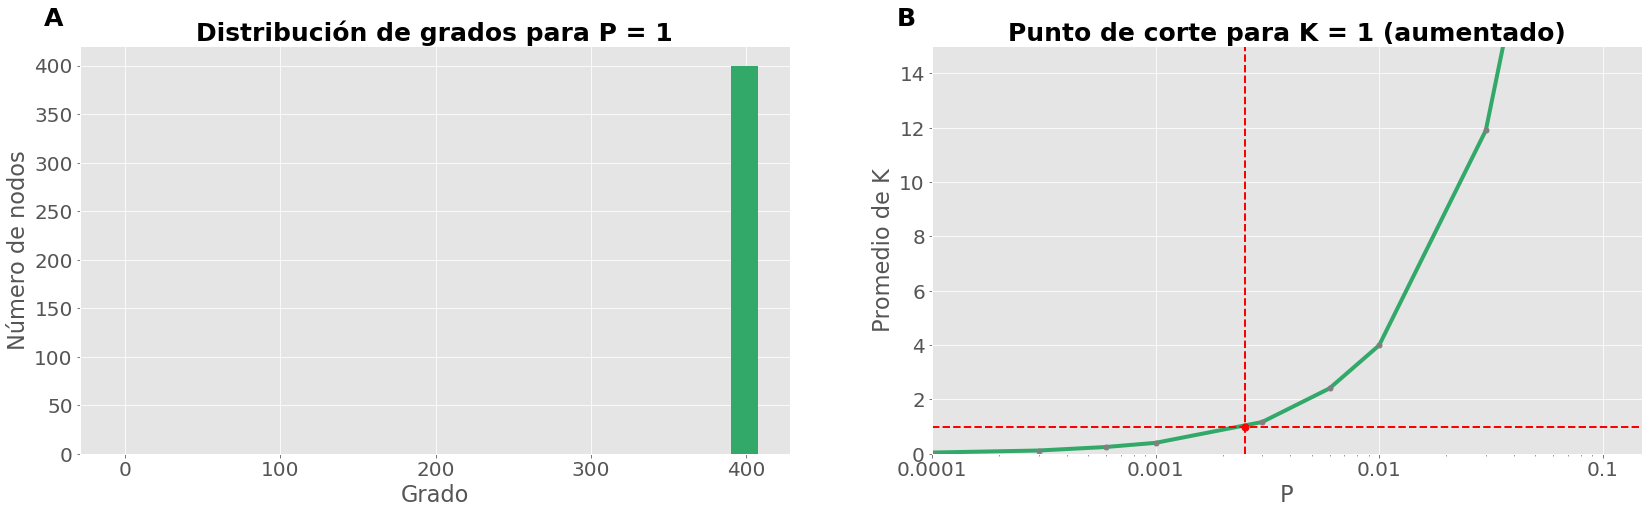

In [5]:
degree_GAL = nx.degree_histogram(nx.gnp_random_graph(400, 1))

G_titles_2 = ["Distribución de grados para P = 1", "Punto de corte para K = 1 (aumentado)"]

fig, axs = plt.subplots(1, 2, figsize = (28, 7.5))

for nax, ax in enumerate(axs.flat):
    if nax == 0:
        ax.bar(range(len(degree_GAL)), degree_GAL, color = "#32a869", width = 17)
        ax.set_ylabel("Número de nodos", fontsize = textSize * 0.9)
        ax.set_xlabel("Grado", fontsize = textSize * 0.9)
    else:
        ax.plot(Probs, G_random_metrics[2], linewidth = lineW, color = "#32a869")
        ax.plot(Probs, G_random_metrics[2], "o", color = "grey", markersize = 5)
        ax.plot(1/399, 1, 'o', markersize = 7, c = "r")
        ax.axvline(1/399, color = "red", linewidth = 2, linestyle = "dashed")
        ax.axhline(1, color = "red", linewidth = 2, linestyle = "dashed")        
        ax.set_xlim(0.0001, 0.15)
        ax.set_ylim(0, 15)
        ax.set_ylabel(G_ylabels[2], fontsize = textSize * 0.9)
        ax.set_xlabel("P", fontsize = textSize * 0.9)
        ax.set_xscale("log", nonposx = 'clip')
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.set_title(G_titles_2[nax], fontweight = "bold", fontsize =  textSize)
    ax.tick_params(labelsize = textSize * 0.8)
    ax.text(-0.05, 1.05, string.ascii_uppercase[nax], transform = ax.transAxes, 
            size = textSize + 0.2, weight = 'bold')

Con el objetivo de determinar a partir de qué valores de $P$ dados el grafo está compuesto por una única componente conexa, el siguiente código muestra que es a partir de $P$ = 0.03. En dicho punto, $K \approx 12$, lo cual concuerda con los cálculos teóricos que determinan que el grafo se vuelve conexo cuando $K > ln(N)$, siendo en este caso $ln(400) = 5.99$. Dado que también se puede determinar $L$ analíticamente mediante la expresión $L = \frac{log(N)}{log(k)}$ cuando el grafo es conexo, en este punto, en el cual $P = \frac{6}{399} = 0.015$, el camino característico $L = 3.35$, es decir, presenta valores cercanos a 1 que tenderán a 1 cuando $K = N - 1$.

In [6]:
for i in Probs:
    if nx.is_connected(nx.gnp_random_graph(400, i)):
        print(">> P = {}: el grafo es conexo.".format(i))
    else:
        print(">> P = {}: el grafo no es conexo.".format(i))

>> P = 0: el grafo no es conexo.
>> P = 0.0001: el grafo no es conexo.
>> P = 0.0003: el grafo no es conexo.
>> P = 0.0006: el grafo no es conexo.
>> P = 0.001: el grafo no es conexo.
>> P = 0.003: el grafo no es conexo.
>> P = 0.006: el grafo no es conexo.
>> P = 0.01: el grafo no es conexo.
>> P = 0.03: el grafo es conexo.
>> P = 0.06: el grafo es conexo.
>> P = 0.1: el grafo es conexo.
>> P = 0.3: el grafo es conexo.
>> P = 0.6: el grafo es conexo.
>> P = 1.0: el grafo es conexo.


Respecto a los valores de $L$ previos al punto en el que el grafo se vuelve conexo, en lugar de asumir $L = N - 1$, otra posibilidad consiste en calcular el camino característico para la componente conexa de mayor tamaño. A pesar de que los valores de $L$ previos a $P_c$ no serán representativos del grafo, sí es una manera visual de entender qué está ocurriendo conforme $P$ aumenta, ya que se irá generando la componente conexa gigante que acabará ocupando todo el grafo. Para su análisis, se va a utilizar la misma aproximación que en el apartado anterior, pero cambiando el argumento ``Lmax = False``. 

Como se puede observar en el siguiente gráfico A, $L$ aumenta conforme aumenta $P$ hasta llegar a un máximo en $P = 0.003$. A partir de dicho punto, los valores de $L$ caen hasta alcanzar la $P_c$, donde el grafo ya es conexo y $L$ describe la misma progresión que en el apartado anterior (mirar gráfico B de la siguiente celda). El paso desde $P = 0.0001$ hasta $P = 0.003$ puede deberse a que, a partir de dicho punto, la componente conexa comienza a aumentar su tamaño y, por tanto, los nodos comienzan a separarse más. Sin embargo, con $P$ mayores, el camino característico desciende hasta que $P = 1$, alcanzando su mínimo ($L = 1$). En cualquier caso, los valores representados son muy bajos en relación al tamaño del grafo, por lo que se podría confirmar que, durante toda su evolución, el grafo presenta valores de $L$ relativamente pequeños. 

In [7]:
if os.path.isfile("data/G_random_metrics_Lmax.pkl"):
    with open("data/G_random_metrics_Lmax.pkl", "rb") as file:
        G_random_metrics_Lmax = pickle.load(file)
else:    
    C_results_Lmax = []
    L_results_Lmax = []
    K_results_Lmax = []
    for P in Probs:
        Indiv_results_Lmax = L_C_Aleatorio(20, 400, P, Lmax = False)
        C_results_Lmax.append(Indiv_results_Lmax[1])
        L_results_Lmax.append(Indiv_results_Lmax[0])
        K_results_Lmax.append(Indiv_results_Lmax[2])

    G_random_metrics_Lmax = [C_results_Lmax, L_results_Lmax, K_results_Lmax]
    
    with open("data/G_random_metrics_Lmax.pkl", "wb") as file:
        pickle.dump(G_random_metrics_Lmax, file, -1)

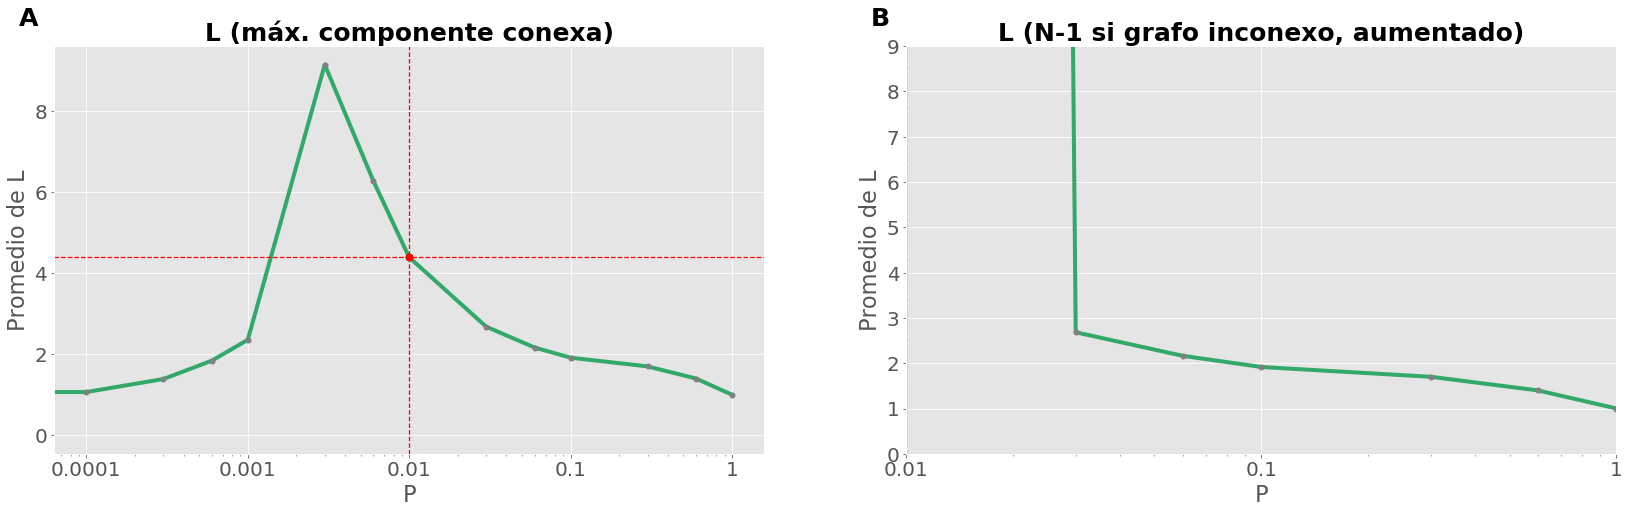

In [8]:
G_titles_3 = ["L (máx. componente conexa)", "L (N-1 si grafo inconexo, aumentado)"]

# Representación 
fig, axs = plt.subplots(1, 2, figsize = (28, 7.5))

G_Lmax = [G_random_metrics_Lmax, G_random_metrics]

for nax, ax in enumerate(axs.flat):    
    ax.plot(Probs, G_Lmax[nax][1], linewidth = lineW, color = "#32a869")
    ax.plot(Probs, G_Lmax[nax][1], "o", color = "grey", markersize = 5)
    ax.set_title(G_titles_3[nax], fontweight = "bold", fontsize =  textSize)
    ax.text(-0.05, 1.05, string.ascii_uppercase[nax], transform = ax.transAxes, size = textSize + 0.2,
            weight = 'bold')
    ax.set_ylabel(G_ylabels[1], fontsize = textSize * 0.9)
    ax.set_xlabel("P", fontsize = textSize * 0.9)
    ax.set_xscale("log", nonposx = 'clip')
    ax.tick_params(labelsize = textSize * 0.8)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.plot(0.01, G_Lmax[nax][1][7], 'o', markersize = 7, c = "r")
    ax.axvline(0.01, color = "red", linewidth = 1.25, linestyle = "dashed")
    ax.axhline(G_Lmax[nax][1][7], color = "red", linewidth = 1.25, linestyle = "dashed")
    if nax == 1:
        ax.set_xlim(0.01, 1)
        ax.set_ylim(0, 9)

### 2. Redes regulares y de mundo pequeño

**a. Usando la función de NetworkX ``watts_strogatz_graph(n, k, p)`` implementad una rutina Python ``L_C_small_world(n_graph, n, k, p)`` que devuelva valor promedio de los coeficientes C (índice de clusterización promedio) y L (camino característico) para un conjunto de n_graph grafos de tipo Small World.** El formato de la función debe ser:

`` [l,c] = L_C_Small_World(n_graph,n,k,p)``

Nota: En el caso de que el grafo no sea conexo, usad el valor n-1 para L en ese grafo.

Al igual que en el caso anterior, la función ``L_C_Small_World`` no solo devuelve los valores de $C$ y $L$, sino también los de $K$, aunque en este caso es uno de los parámetros necesarios para la función ``watts_strogatz_graph`` y, por tanto, es introducido por el usuario. Además, una de las particularidades de este modelo es que $K$ inicial se mantiene constante para cualquier $P$, es decir, solo se modifica la posición de las ramas, no el número total de las mismas en el grafo. 

Dicha función parte de un grafo regular con un número de nodos y ramas especificado y, en función de $P$ (probabilidad de cambiar de posición cada una de las ramas), la posición de éstas varía siguiendo una distribución aleatoria. Esta función no asegura que los grafos resultantes sean conexos, razón por la cual se decide coger $L = N - 1$ en dichos casos y, además, el número de ramas inicial se mantiene constante. 

In [9]:
# Definición de la función L_C_Small_World
def L_C_Small_World(n_graph, n, K, P, Lmax = True):
    C = []
    L = []
    for graph in range(n_graph):
        G = nx.watts_strogatz_graph(n, K, P)
        C.append(nx.average_clustering(G))
        # Cuando el grafo es conexo, se puede usar la función de cálculo del camino característico pero, cuando
        # no, L = n - 1 porque es el valor máximo de camino característico.
        if nx.is_connected(G):
            L.append(nx.average_shortest_path_length(G))
        else:
            if Lmax:
                L.append(n - 1)
            else:
                G_max = max_connected(G)
                L.append(nx.average_shortest_path_length(G_max))
        
    return round(sum(L)/len(L), 3), round(sum(C)/len(C), 3), K

**b. Usando la rutina anterior, generad una gráfica con el comportamiento de C y L para distintos valores de la probabilidad p y un número fijo de nodos y ramas.** 

* Tomad N=400, k=8 y los siguientes valores de p: [0, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1.].

* ¿Para qué probabilidades p se producen cambios fase en el comportamiento los parámetros L y C? ¿Entre que valores de p dirías que está la zona de Small-World para estos valores de N y k. ¿Corresponde el valor de p observado con el valor de p teórico para el cambio de fase en el comportamiento del camino característico?

* Comparar las gráficas obtenidas de C y L con las correspondientes gráficas teóricas.

* Con los datos que obtuviste en la práctica 1. ¿Dirías que la red de interacción de proteínas del _Caernobidis elegans_ puede ser considerada una red de mundo pequeño? Razona la respuesta.

In [10]:
if os.path.isfile("data/G_SW_metrics.pkl"):
    with open("data/G_SW_metrics.pkl", "rb") as file:
        G_SW_metrics = pickle.load(file)
else:    
    C_results_2 = []
    L_results_2 = []
    K_results_2 = []
    for P in Probs:
        Indiv_results_2 = L_C_Small_World(20, 400, 8, P)
        C_results_2.append(Indiv_results_2[1])
        L_results_2.append(Indiv_results_2[0])
        K_results_2.append(Indiv_results_2[2])
    
    G_SW_metrics = [C_results_2, L_results_2, K_results_2]
    
    with open("data/G_SW_metrics.pkl", "wb") as file:
        pickle.dump(G_SW_metrics, file, -1)

Al igual que en el caso de los grafos aleatorios, el gráfico D se corresponde con la visualización conjunta de los valores promedio de $L$ y $C$ mediante el reescalado de los valores de $L$ obtenido de la división de estos por su máximo (en este caso, 25.439).

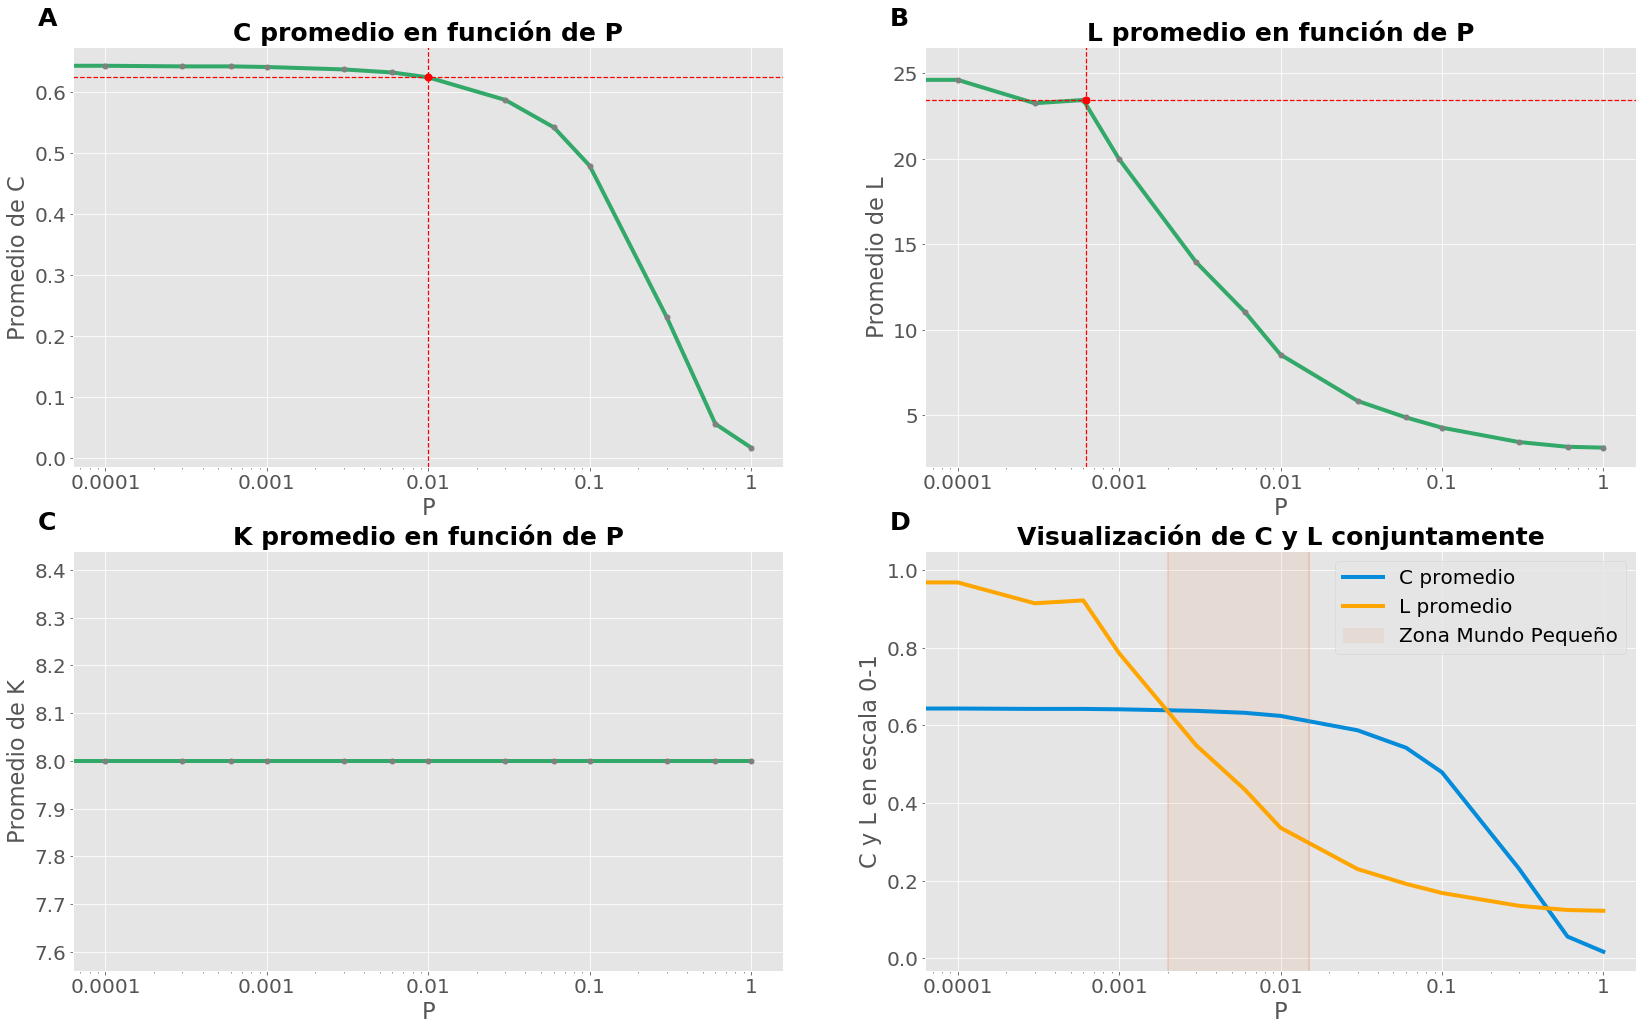

In [11]:
P1 = 0.002
P2 = 0.015

# Representación 
fig, axs = plt.subplots(2, 2, figsize = (28, 17))

for nax, ax in enumerate(axs.flat):
    if nax != 3:
        ax.plot(Probs, G_SW_metrics[nax], linewidth = lineW, color = "#32a869")
        ax.plot(Probs, G_SW_metrics[nax], "o", color = "grey", markersize = 5)
    else:
        ax.plot(Probs, G_SW_metrics[0], linewidth = lineW, color = "#048bd9", label = "C promedio")
        ax.plot(Probs, np.array(G_SW_metrics[1])/max(G_SW_metrics[1]), linewidth = lineW, 
                color = "orange", label = "L promedio")
        ax.axvline(P1, linewidth = 2, alpha = 0.2, color = "#eb7a42")
        ax.axvline(P2, linewidth = 2, alpha = 0.2, color = "#eb7a42")
        ax.axvspan(P1, P2, alpha = 0.1, color = "#eb7a42", label = "Zona Mundo Pequeño")
        ax.legend(loc = "best", prop = {'size': textSize * 0.8})
    ax.set_title(G_titles[nax], fontweight = "bold", fontsize =  textSize)
    ax.text(-0.05, 1.05, string.ascii_uppercase[nax], transform = ax.transAxes, size = textSize + 0.2,
            weight = 'bold')
    ax.set_ylabel(G_ylabels[nax], fontsize = textSize * 0.9)
    ax.set_xlabel("P", fontsize = textSize * 0.9)
    ax.set_xscale("log", nonposx = 'clip')
    ax.tick_params(labelsize = textSize * 0.8)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    if nax == 0:
        ax.plot(0.01, G_SW_metrics[nax][7], 'o', markersize = 7, c = "r")
        ax.axvline(0.01, color = "red", linewidth = 1.25, linestyle = "dashed")
        ax.axhline(G_SW_metrics[nax][7], color = "red", linewidth = 1.25, linestyle = "dashed")
    if nax == 1:
        ax.plot(0.000625, G_SW_metrics[nax][3], 'o', markersize = 7, c = "r")
        ax.axvline(0.000625, color = "red", linewidth = 1.25, linestyle = "dashed")
        ax.axhline(G_SW_metrics[nax][3], color = "red", linewidth = 1.25, linestyle = "dashed")

En el caso del modelo de Watts y Strogatz [3] para la generación de **Redes de Mundo Pequeño**, se parte de un anillo (grafo regular) que debe cumplir la condición $N >> K >> log(N)$, con el objetivo de que el grafo sea poco denso, pero conexo. En él, la posición de las ramas se modificará o no en función de la probabilidad $P$, evitando ramas dobles y autoconexiones. 

* En el caso de que $P = 0$, ninguna de las ramas del sustrato inicial se modificará y el grafo será regular, cuyos nodos estarán conectados con sus $2m$ vecinos a izquierda y derecha. En este contexto: el grado medio será igual a $K = 2m$, en este caso 8; y la distribución de grados será una Delta de Dirac (mirar gráfico A resultante de la siguiente celda). Además, tanto $L$ como $C$ presentarán valores altos, propios de los grafos regulares.

* Por el contrario, cuando $P = 1$, todas las ramas del grafo habrán sido cambiadas aleatoriamente, de forma que se obtendrá un grafo aleatorio con valores $L$ y $C$ bajos y con una distribución de grados Binomial (de Poisson cuando $N$ tiende a infinito; mirar gráfico C resultante de la siguiente celda). 

Por lo tanto, los gráficos anteriores se pueden interpretar como la progresión de las métricas durante la transición desde un grafo regular ($P = 1$) a un grafo aleatorio ($P = 0$) mediante la modificación de la posición de las ramas, pero sin variar el grado medio del grafo. 

$$
  \renewcommand{\arraystretch}{1.2}
  \left\{\begin{array}{l @{\quad} l r l}
        K = K, & C \approx (0.5, 1), & L = \frac{N}{2K}, & \text{if } P = 0\\
        K = K, & C \approx 0, & L \approx log(N), & \text{if } P = 1
  \end{array}\right.
\tag{2}
$$

Es para valores intermedios de $P$ la zona en la que se encuentran las Redes de Mundo Pequeño, las cuales se caracterizan por presentar tanto características propias de grafos aleatorios como de grafos regulares. Se puede definir la **zona de mundo pequeño** como aquella en la que $C$ es más o menos igual que en un grafo regular y $L$ es más o menos igual que en un grafo aleatorio, es decir, aquella con un índice de clusterización alto y un camino característico bajo. 

En base a los gráficos, se puede ver cómo efectivamente los valores de $L$ caen con $P$ más bajas que los valores de $C$, los cuales permanecen más o menos constantes hasta su caída con valores de $P$ más altos, indicando que el cambio de ramas no produce grandes efectos a nivel local ($C$ se mantiene constante más tiempo), pero sí a nivel global (aparición de atajos). Por tanto, se cumple el comportamiento teórico esperado para este tipo de redes. Observando el gráfico D, se puede establecer de forma aproximada que la zona de mundo pequeño se encuentra entre $P_1 = 0.002$ y $P_2 = 0.015$ pues, para $P_1$, $L$ presenta valores relativamente bajos y, para $P_2$, comienza la caída de $C$ de forma más pronunciada. 

Dado el marco teórico del modelo de Watts y Strogatz [3], se puede calcular analíticamente el valor de $P$ para el que se produce el descenso de $L$ mediante la expresión $P \geq \frac{2}{NK}$, siendo en la red de estudio $P \geq 0.000625$ $(10^{-6.25})$. El evento que se produce en dicho punto es la aparición de un atajo, es decir, una rama que conecta dos agrupaciones de nodos distintos, haciendo que la distancia entre los nodos decrezca rápidamente. Además, es llamativo ver cómo evoluciona $L$ antes y después de dicho punto: para valores menores que $P_c$, $L$ cae de forma lineal, mientras que a partir de dicho punto, el descenso se vuelve mucho más pronunciado (caída logarítmica).

Otra característica llamativa de las redes de mundo pequeño generadas mediante este modelo es que, dado que al cambiar la posición de las ramas se aumenta la variabilidad respecto a la distribución de grados, es decir, se aumenta la varianza, se acabará pasando de una distribución Delta a una distribución de Poisson, siendo esta última la que presentan los grafos con $P$ dentro de la zona de mundo pequeño (mirar gráfico B resultante de la siguiente celda). 

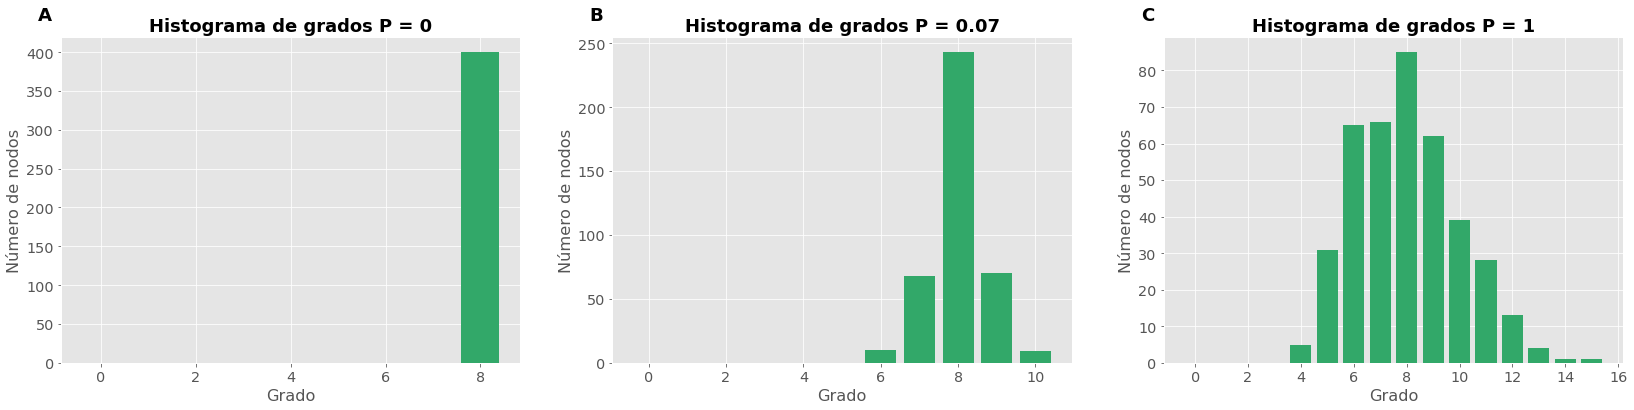

In [12]:
# Representación
degree_SW = [nx.degree_histogram(nx.watts_strogatz_graph(400, 8, i)) 
             for i in [0, 0.07, 1]]

G_titles_4 = ["Histograma de grados P = 0", "Histograma de grados P = 0.07",
             "Histograma de grados P = 1"]
textSize = 18

fig, axs = plt.subplots(1, 3, figsize = (28, 6))

for nax, ax in enumerate(axs.flat):
    ax.bar(range(len(degree_SW[nax])), degree_SW[nax], color = "#32a869")
    ax.set_ylabel("Número de nodos", fontsize = textSize * 0.9)
    ax.set_xlabel("Grado", fontsize = textSize * 0.9)
    ax.set_title(G_titles_4[nax], fontweight = "bold", fontsize =  textSize)
    ax.tick_params(labelsize = textSize * 0.8)
    ax.text(-0.05, 1.05, string.ascii_uppercase[nax], transform = ax.transAxes, 
            size = textSize + 0.2, weight = 'bold')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

Respecto a la comparación de las gráficas obtenidas con las teóricas correspondientes al artículo original de Watts y Strogatz [3] (mirar siguiente figura), se puede observar que tanto para la progresión de $C$ como de $L$ son bastante parecidas, si bien en las teóricas el camino característico cae antes y se parte de un índice de clusterización más alto (debido a la normalización, ver siguiente párrafo). Hay que tener en cuenta que tanto el tamaño como el orden del grafo inicial que los investigadores utilizaron son distintos a los representados anteriormente: Watts y Strogatz [3] partieron de un anillo regular con $N = 1000$ y $K = 10$, mientras que el sustrato inicial utilizado anteriormente es de $N = 400$ y $K = 8$.

Cabe destacar que, como los autores comentan en el artículo, dicha gráfica se ha llevado a cabo mediante la normalización de los valores por los obtenidos con $C(0)$ y $L(0)$, razón por la que $C$ presenta como máximo 1 cuando, por definición del modelo (mirar Ecuación 3), esto no es posible. Las expresiones matemáticas que describen la progresión de ambos valores a través de diferentes valores de $P$ son las siguientes:

$$C(P) = \frac{3(k-2)}{4(k-1)}(1-P)^3 \tag{3}$$

$$L(N, P) \approx \frac{N}{K}f(PKN^d) \tag{4}$$

donde:

$$f(u) = \begin{cases}
   \text{cte} & \text{if } u << 1\\
    \frac{ln(u)}{u} & \text{if } u >> 1
\end{cases}$$

<img src="./figures/small_world_figure.webp">

Respecto a la red de _C. elegans_ de la práctica anterior, teniendo en cuenta la comparación que se llevó a cabo frente a un grafo aleatorio del mismo tamaño y orden, se podría inferir que, a priori, se trata de una red de mundo pequeño, ya que presentaba valores de $C$ mayores a los del grafo aleatorio. 

Sin embargo, se necesita un análisis más profundo para determinar si efectivamente se trata de un grafo que está en la zona de mundo pequeño como, por ejemplo, comparar los valores de $L$. La red de _C. elegans_ no es conexa, por lo que no se puede calcular $L$, ya que se trata de una medida global. En esta ocasión, en lugar de asumir que $L = N - 1$ cuando el grafo es inconexo, se va a coger la componente conexa de mayor tamaño y a llevar a cabo los cálculos sobre ella. Así mismo, dicha aproximación se seguirá también sobre el grafo aleatorio, aunque se debe tener en cuenta que, debido al sesgo estructural que presenta la red de _C. elegans_ (demostrado en la práctica anterior), el tamaño y el orden de ambas serán muy diferente, por lo que no serán valores del todo comparables (mirar Tabla resultante de la celda siguiente).

In [13]:
G_CE = nx.read_edgelist("data/CaernoElegans-LC_uw.txt")
# Componente conexa de mayor tamaño
G_CE_max = max_connected(G_CE)

n = nx.number_of_nodes(G_CE)
m = nx.number_of_edges(G_CE)

G_AL = nx.gnm_random_graph(n, m)
# Componente conexa de mayor tamaño
G_AL_max = max_connected(G_AL)


metrics = []
for i in [G_CE, G_AL, G_CE_max, G_AL_max]:
    metrics.append(re.split(":\s+|\n", nx.info(i).strip())[3:])
    
metrics_df = pd.DataFrame({"Número de componentes conexas": (nx.number_connected_components(G_CE), 
                                                          nx.number_connected_components(G_AL),
                                                          nx.number_connected_components(G_CE_max),
                                                          nx.number_connected_components(G_AL_max)),
                       "Número de nodos": (n, metrics[1][1],  metrics[2][1], metrics[3][1]),
                       "Número de ramas": (m, metrics[1][3],  metrics[2][3], metrics[3][3]),
                       "Grado medio": (metrics[0][5], metrics[1][5],  metrics[2][5], metrics[3][5])},
                       index = ["Red C. elegans", "Red aleatoria", 
                                "Red C. elegans componente conexa", 
                                "Red aleatoria componente conexa"])
metrics_df

,Número de componentes conexas,Número de nodos,Número de ramas,Grado medio
Red C. elegans,89,1387,1648,2.3764
Red aleatoria,145,1387,1648,2.3764
Red C. elegans componente conexa,1,993,1300,2.6183
Red aleatoria componente conexa,1,1215,1620,2.6667


Como se observa en la tabla anterior, el número de componentes conexas de la red _C. elegans_ es mucho menor que para un grafo aleatorio del mismo tamaño y orden, lo que parece indicar un sesgo estructural. Además, dicho sesgo se ve traducido de la misma forma en el orden y el tamaño de la mayor componente conexa, ya que para la red biológica los valores son más altos, excepto para el grado medio, donde ambos se aproximan. 

Respecto al cálculo de los valores de $C$ y $L$, con el fin de ser más precisos, se van a llevar a cabo 50 grafos aleatorios mediante la función ``L_C_Random()``, rutina que sigue la misma idea que las anteriores, pero implementa ``nx.gnm_random_graph(n, m)`` para la generación de los grafos. Se compararán los valores medios obtenidos con los de la red de estudio.

In [14]:
# Definición de la función L_C_Random
def L_C_Random(n_graph, n, m):
    C = []
    L = []
    for graph in range(n_graph):
        G = nx.gnm_random_graph(n, m)
        C.append(nx.average_clustering(G))
        if nx.is_connected(G):
            L.append(nx.average_shortest_path_length(G))
        else:
            G_max = max_connected(G)
            L.append(nx.average_shortest_path_length(G_max))
            
    return sum(L)/len(L), sum(C)/len(C)

In [15]:
if os.path.isfile("data/G_AL_CE_metrics.pkl"):
    with open("data/G_AL_CE_metrics.pkl", "rb") as file:
        G_AL_CE_metrics = pickle.load(file)
else:    
    G_AL_CE_metrics = L_C_Random(50, n, m)
        
    with open("data/G_AL_CE_metrics.pkl", "wb") as file:
        pickle.dump(G_AL_CE_metrics, file, -1)

# Métricas de la red de C. elegans
L_CE = nx.average_shortest_path_length(G_CE_max)
C_CE = nx.average_clustering(G_CE)

In [16]:
LC_df = pd.DataFrame({"Camino característico (L)": (L_CE, G_AL_CE_metrics[0]),
                      "índice de clusterización (C)": (C_CE, G_AL_CE_metrics[1])},
                       index = ["Red C. elegans", "Red aleatoria"])
LC_df

,Camino característico (L),índice de clusterización (C)
Red C. elegans,7.922565,0.075708
Red aleatoria,7.963754,0.001302


Como se puede observar en la tabla anterior, los valores de $L$ para la red aleatoria y para _C. elegans_ son muy parecidos. Además, son muy bajos teniendo en cuenta el tamaño de los grafos de partida ($\approx 1626$ para la componente conexa de mayor tamaño en los grafos aleatorios y 1300 para la de la red de _C. elegans_ ) por lo que, con respecto a este parámetro, nuestra red cumple la condición para ser de mundo pequeño. 

En cuanto a los valores de $C$, se puede observar cómo la red _C. elegans_ presenta un índice de clusterización que, aunque a priori pudiera parecer bajo, para el orden y el tamaño con el que cuenta es alto, ya que está dos órdenes de magnitud por encima del que presenta una red aleatoria con las mismas características. De hecho, si se llevara a cabo el mismo procedimiento que en los apartados anteriores con la función ``L_C_Small_World`` con un $N$ y un $K$ iguales a los de la red de estudio, se observaría cómo efectivamente los valores de $C$ estarían en torno a 0 a lo largo de las diferentes $P$, aunque no es una aproximación correcta por el hecho de que con el procedimiento de Watts y Strogatz no se controla el tamaño del grafo (resultados no mostrados).

Por lo tanto, se puede confirmar que la red de interacción de proteínas de _C. elegans_ pertenece a las redes de Mundo Pequeño, lo cual es propio de la mayoría de las redes biológicas. Cabe destacar que, como se demostró en el entregable anterior, esta red también es libre de escala, ya que la distribución de grados en escala logarítimica-logarítmica se ajusta a una recta y ambos tipos de redes no son excluyentes. Este hecho podría explicar que presente un índice de clusterización relativamente bajo en comparación a una red de mundo pequeño arquetípica, ya que las redes libres de escala suelen presentar un $C$ medio-bajo (aunque depende del modelo a partir del cual se generen). 

### 3. Redes libres de Escala

**a. Generad una red libre de escala con 10000 nodos y que añade 10 nodos en cada paso (utilizad la rutina barabasi_albert_graph(n, m)).** Calculad los valores de L, C y la distribución de grado de los nodos. Generad una red aleatoria que tenga el mismo número de nodos y ramas que la red que habéis creado, calculad sus valores de L, C y la distribución del grado de los nodos y comparad los valores obtenidos.

In [17]:
if os.path.isfile("data/G_SF_metrics.pkl"):
    with open("data/G_SF_metrics.pkl", "rb") as file:
        G_SF_metrics = pickle.load(file)
else:
    G_SF = nx.barabasi_albert_graph(10000, 10)
    C_SF = nx.average_clustering(G_SF)
    L_SF = nx.average_shortest_path_length(G_SF)
    m_SF = nx.number_of_edges(G_SF)
    Degree_dist_SF = nx.degree_histogram(G_SF)
    
    G_SF_metrics = [C_SF, L_SF, m_SF, Degree_dist_SF]
    
    with open("data/G_SF_metrics.pkl", "wb") as file:
        pickle.dump(G_SF_metrics, file, -1)

In [18]:
if os.path.isfile("data/G_random_SF_metrics.pkl"):
    with open("data/G_random_SF_metrics.pkl", "rb") as file:
        G_random_SF_metrics = pickle.load(file)
else:
    G_AL = nx.gnm_random_graph(10000, G_SF_metrics[2])
    C_AL = nx.average_clustering(G_AL)
    L_AL = nx.average_shortest_path_length(G_AL)
    Degree_dist_AL = nx.degree_histogram(G_AL)
    
    G_random_SF_metrics = [C_AL, L_AL, Degree_dist_AL]
    
    with open("data/G_random_SF_metrics.pkl", "wb") as file:
        pickle.dump(G_random_SF_metrics, file, -1)


Las gráficas A y B corresponden a la red libre de escala, mientras que las C y D corresponden a la
aleatoria equivalente.

Las gráficas E y F corresponden a la red libre de escala aumentadas entre los grados 8-100 y 100-550,
respectivamente.


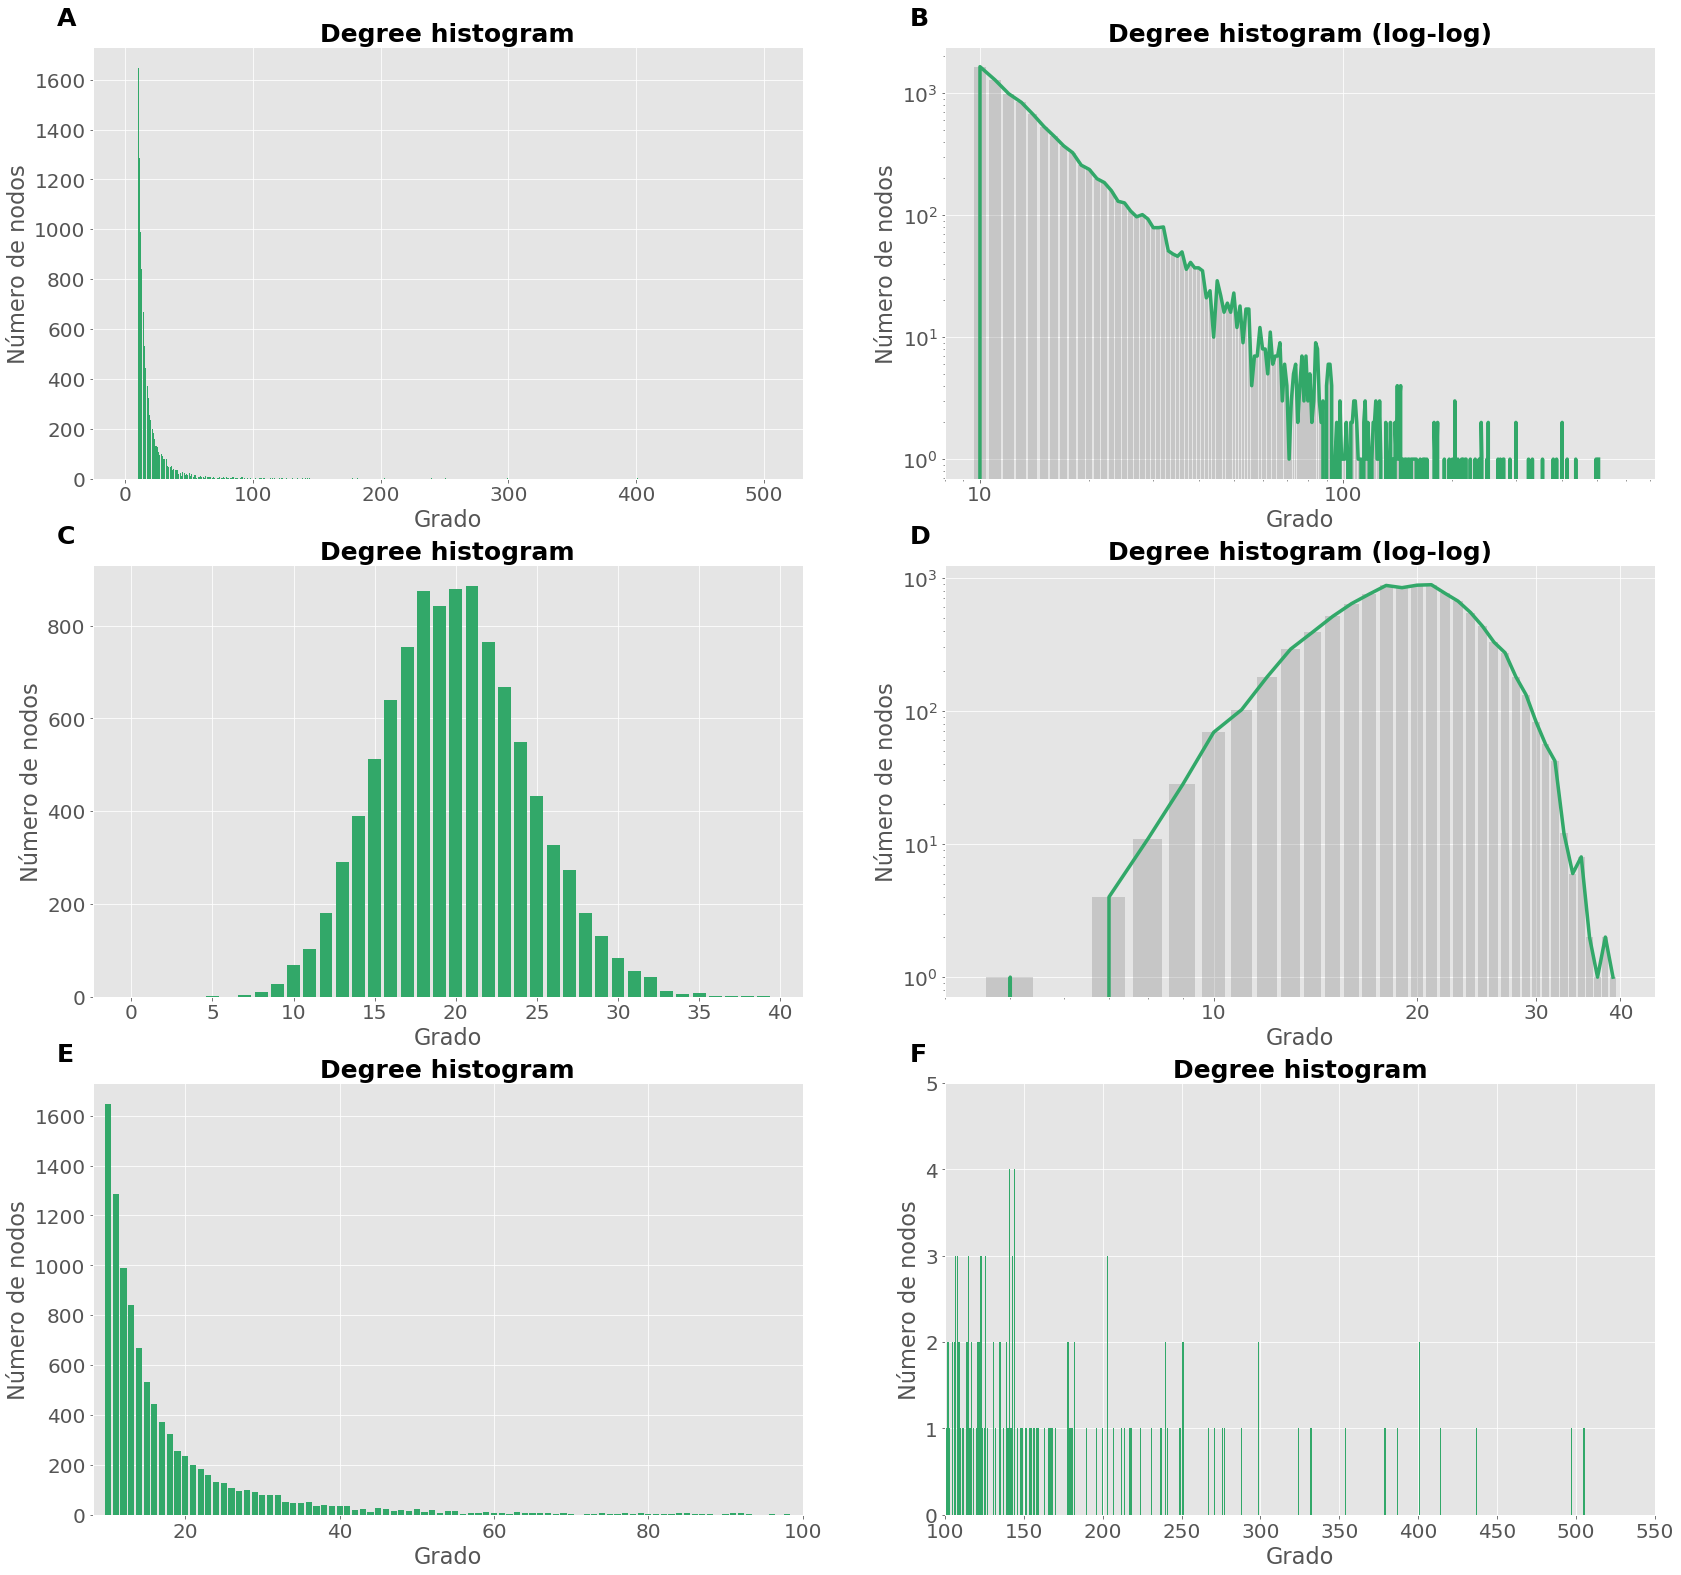

In [19]:
# Representación
fig, axs = plt.subplots(3, 2, figsize = (28, 27))
textSize = 25
lineW = 3.5

Degree_dists = [G_SF_metrics[3], G_SF_metrics[3], 
                G_random_SF_metrics[2], G_random_SF_metrics[2],
                G_SF_metrics[3], G_SF_metrics[3]]

print("\nLas gráficas A y B corresponden a la red libre de escala, mientras que las C y D corresponden a la",
      "aleatoria equivalente.", sep = "\n")
print("\nLas gráficas E y F corresponden a la red libre de escala aumentadas entre los grados 8-100 y 100-550,",
      "respectivamente.", sep = "\n")

for nax, ax in enumerate(axs.flat):
    if (nax != 1) and (nax != 3):
        ax.bar(range(len(Degree_dists[nax])), Degree_dists[nax], color = "#32a869")
        ax.set_title("Degree histogram", fontweight = "bold", fontsize =  textSize)
        if nax == 4:
            ax.set_xlim(8, 100)
        elif nax == 5:
            ax.set_xlim(100, 550)
            ax.set_ylim(0, 5)
        ax.set_ylabel("Número de nodos", fontsize = textSize * 0.9)
        ax.set_xlabel("Grado", fontsize = textSize * 0.9)
    elif (nax == 1) or (nax == 3):
        ax.bar(range(len(Degree_dists[nax])), Degree_dists[nax], color = "grey", alpha = 0.3)
        ax.plot(range(len(Degree_dists[nax])), Degree_dists[nax], linewidth = lineW, color = "#32a869")
        ax.set_title("Degree histogram (log-log)", fontweight = "bold", fontsize =  textSize)
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log", nonposy='clip')
        ax.set_ylabel("Número de nodos", fontsize = textSize * 0.9)
        ax.set_xlabel("Grado", fontsize = textSize * 0.9) 
        ax.set_xlim(8)
        if nax == 3:
            ax.set_xticks(range(min(Degree_dists[nax]), max(Degree_dists[nax]), 10))
            ax.set_xlim(4, 45)
    
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.text(-0.05, 1.05, string.ascii_uppercase[nax], transform = ax.transAxes,
            size = textSize + 0.2, weight = 'bold') 
    ax.tick_params(labelsize = textSize * 0.8)

In [20]:
print("El índice de clusterización de la red libre de escala creada es:", G_SF_metrics[0])
print("El camino característico de la red libre de escala creada es:", G_SF_metrics[1], "\n")
print("El índice de clusterización de la red aleatoria equivalente a la libre de escala creada es:",
      G_random_SF_metrics[0])
print("El camino característico de la red aleatoria equivalente a la libre de escala creada es:",
      G_random_SF_metrics[1])

El índice de clusterización de la red libre de escala creada es: 0.010874369768007174
El camino característico de la red libre de escala creada es: 3.062825502550255 

El índice de clusterización de la red aleatoria equivalente a la libre de escala creada es: 0.0020870545725986843
El camino característico de la red aleatoria equivalente a la libre de escala creada es: 3.403392199219922


El **modelo de las redes libres de escala** fue propuesto por **Lászlo Barabási** y **Réka Albert** con el fin de modelizar características de las redes reales que otros modelos no pueden. La implementación del paquete NetworkX consiste en la generación de un grafo inicial con $m$ nodos y sin ramas que, en cada instante de tiempo, crece con la adición de un nuevo nodo con $\le m$ ramas (en este caso, 10) hasta que el grafo sea del orden de $N$ nodos (en este caso, 10 000). La probabilidad de conexión de cada rama será mayor hacia aquellos nodos con mayor grado. Por lo tanto, **crecimiento** y **conexión preferencial** son las características imprescindibles para que una red sea libre de escala. Haciendo esto, se obtendrá un grafo con muchos nodos con pocas conexiones y unos pocos con muchas ( _hubs_ ), tal y como se representa en los gráficos A, E y F superiores.

Una forma de identificarlas consiste en representar la distribución de grado de los nodos (que sigue una ley de potencias) en escala logarítmica-logarítmica, ya que se ajusta a una **recta de pendiente negativa** que al final tiene un **corte o cutoff**, lo que tiene que ver con que el modelo de creación aumenta los nodos de la red, pero también se quitan, de forma que ese cutoff indica que probablemente han desaparecido nodos de la red. Este comportamiento de la distribución de grado se diferencia de lo que ocurre en un grafo aleatorio (sigue una Poisson; mirar gráfica C superior) o en uno regular (sigue una Delta), el cual, como se puede observar en la gráfica B resultante de la celda superior, se cumple para la red creada. 

Las propiedades de las redes libres de escala son: **camino característico corto**, incluso más que en el grafo aleatorio equivalente; **índice de clusterización pequeño y decreciente** (a mayor número de nodos), pero mayor que el del grafo aleatorio equivalente. En este caso, el índice de clusterización de la red libre de escala es un orden de magnitud mayor que el de la red aleatoria equivalente, de forma que hay un sesgo en la misma; mientras que el camino característico de la red libre de escala es más pequeño que el de la red aleatoria equivalente. Así, ambas propiedades se cumplen.

In [21]:
FS_df = pd.DataFrame({"Camino característico (L)": (G_SF_metrics[1], G_random_SF_metrics[1]),
                      "índice de clusterización (C)": (G_SF_metrics[0], G_random_SF_metrics[0])},
                       index = ["Red libre de escala", "Red aleatoria"])
FS_df

,Camino característico (L),índice de clusterización (C)
Red libre de escala,3.062826,0.010874
Red aleatoria,3.403392,0.002087


### 4. Referencias

* [1] van Steen M (2010) Graph Theory and Complex Networks; An Introduction.

* [2] P. Erdös-A.Rényi (1960) On the evolution of random graphs. Publications of the Mathematical Institute of the Hungarian Academy of Sciences 5.

* [3] Watts DJ, Strogatz SH (1998) Collective dynamics of ‘small-world’ networks. Nature 393: 440–442.

* Así como las transparencias y material derivado de las clases de la asignatura.